# Big Mart Sales Prediction

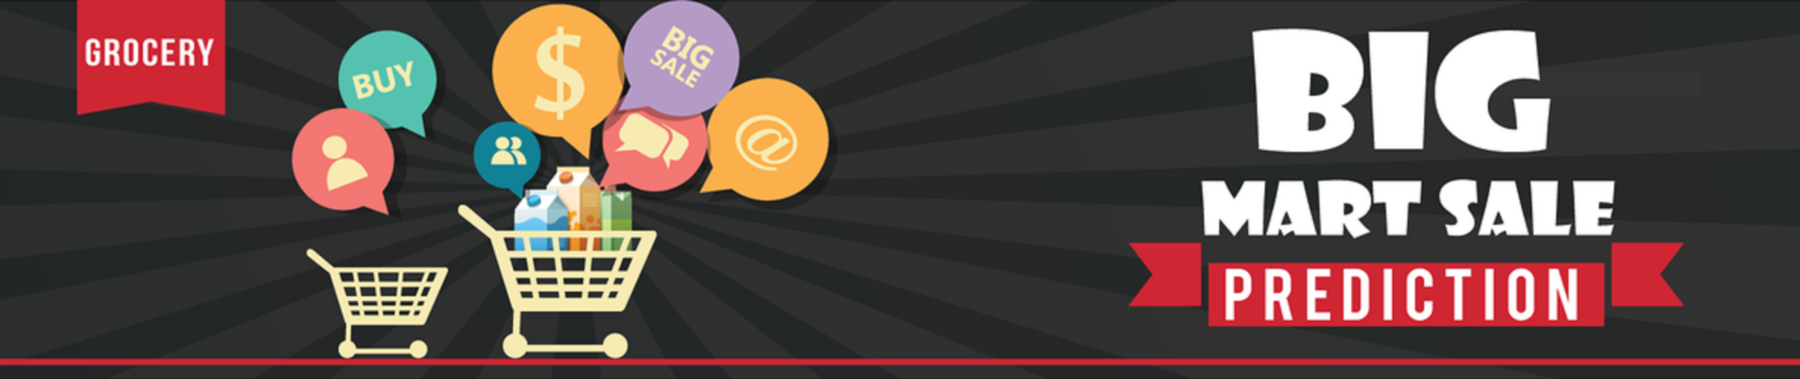

 - Esse projeto tem como o objetivo contruir um modelo que vai prever as vendas de cada produto em uma loja específica.
_______________________________________________________________________________________________________________________________
### Train file variables
Item_Identifier ---- Unique product ID \
Item_Weight ---- Weight of product \
Item_Fat_Content ---- Whether the product is low fat or not\
Item_Visibility ---- The % of the total display area of all products in a store allocated to the particular product\
Item_Type ---- The category to which the product belongs\
Item_MRP ---- Maximum Retail Price (list price) of the product\
Outlet_Identifier ---- Unique store ID\
Outlet_Establishment_Year ---- The year in which the store was established\
Outlet_Size ---- The size of the store in terms of ground area covered\
Outlet_Location_Type ---- The type of city in which the store is located\
Outlet_Type ---- Whether the outlet is just a grocery store or some sort of supermarket\
*Item_Outlet_Sales ---- sales of the product in a particular store. This is the outcome variable to be predicted.
_______________________________________________________________________________________________________________________________

### Submission file format
Variable Description
Item_Identifier ----- Unique product ID\
Outlet_Identifier ----- Unique store ID\
Item_Outlet_Sales ----- Sales of the product in t particular store. This is the outcome variable to be predicted.

## Importando as Bibliotecas

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Importando as bases de treino e teste

In [7]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Train

In [9]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [11]:
colunas_de_texto = [ 
                 'Item_Fat_Content',
                 'Item_Type',
                 'Outlet_Size',
                 'Outlet_Location_Type',
                 'Outlet_Type'
                ]

for coluna in colunas_de_texto:
    print(f"Number of values in the {coluna} column is:\n{train[coluna].value_counts() }")
    print("--" * 30)

Number of values in the Item_Fat_Content column is:
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
------------------------------------------------------------
Number of values in the Item_Type column is:
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
------------------------------------------------------------
Number of values in the Outlet_Size column is:
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64
------------------------------

# Tratando valores vazios

In [12]:
train.shape

(8523, 12)

In [13]:
train.isnull().sum().sort_values(ascending=False)

Outlet_Size                  2410
Item_Weight                  1463
Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

- Vou preencher os valores vazios da coluna Item_Weight pela média dos valores ali dentro. 
- Já para a coluna Outlet_Size usarei a moda dos valores ali dentro, ou seja, o valor que mais se repete. 

## Item_Weight

In [14]:
train.loc[train.Item_Weight.isnull(), 'Item_Weight'] = train.Item_Weight.mean()   

In [15]:
train.isnull().sum().sort_values(ascending=False)

Outlet_Size                  2410
Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

## Outlet_Size

In [16]:
train.Outlet_Type.value_counts()
# Há quatro tipos de lojas 
# Eu posso substituir os valores vazios de Outlet_Size pela moda de cada uma dessas quatro lojas

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [17]:
mode_of_outlet_size = train.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

In [18]:
display(mode_of_outlet_size)

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


Assim, podemos ver a moda em cada tipo de outlet.

In [19]:
train['Outlet_Size'].fillna(train.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.mode()[0]), inplace=True)

In [20]:
train.isnull().sum().sort_values(ascending=False)

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Data Analysis

### Correlação entre features
Se duas colunas tiverem uma correlação muito alta, significa que ambas estão dizendo quase que a mesma coisa, então talvez não seria necessário manter as duas, e sim só uma. Não é que as duas possuem os mesmo valores, mas sim o que estariam dizendo.

<AxesSubplot:>

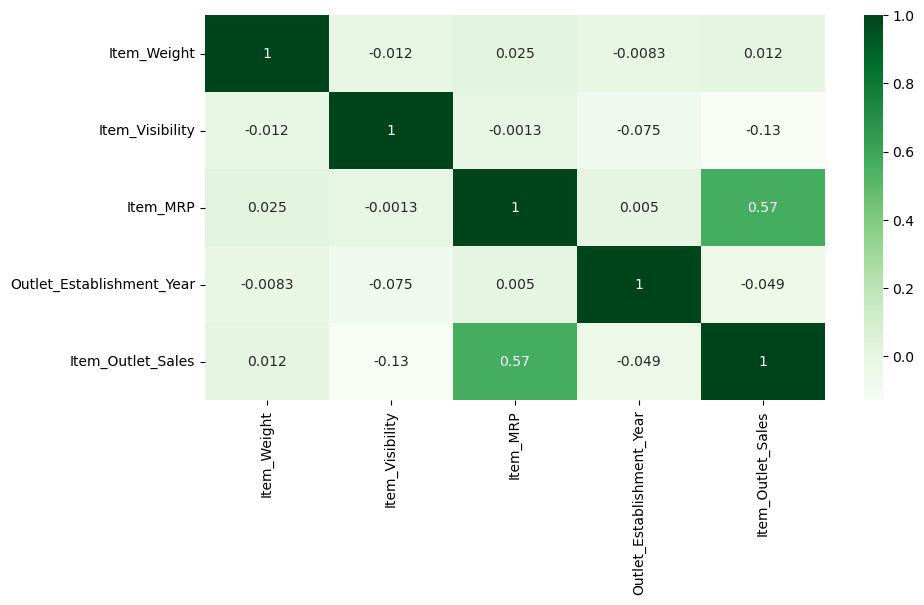

In [21]:
plt.figure(figsize=(10, 5))
sns.heatmap(train.corr(), annot=True, cmap='Greens')

Como podemos ver o Item_MRP e o Item_Outlet_Sales possum uma correlação bastante positiva, o que quer dizer que conforme o MRP do item aumenta, as vendas daquele item também aumentam. O Item_Visibility e o Item_Outlet_Sales apresentam uma correlação negativa, o que quer dizer que se o item é menos visível, as vendas desse item aumentam, assim como, se o item for mais visível, as vendas vão diminuir. 

In [22]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# Feature Engineering

## Valores numéricos

In [23]:
colunas_numericas = train.select_dtypes(include=['float64', 'int64']).columns.tolist()
colunas_numericas

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

## Item_Weight

In [24]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5*amplitude, q3 + 1.5*amplitude

def excluir_outliers(df, nome_coluna): # quero excluir os outliers
    qntd_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna]) # == base_airbnb['price']
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qntd_linhas - df.shape[0]
    return df, linhas_removidas

In [25]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    
def histograma(coluna):
    plt.figure(figsize=(6, 6))
    sns.histplot(data=train, x=coluna, kde=True)
    
def countplot(coluna):
    plt.figure(figsize=(6, 6))
    sns.countplot(data=train, x=coluna)

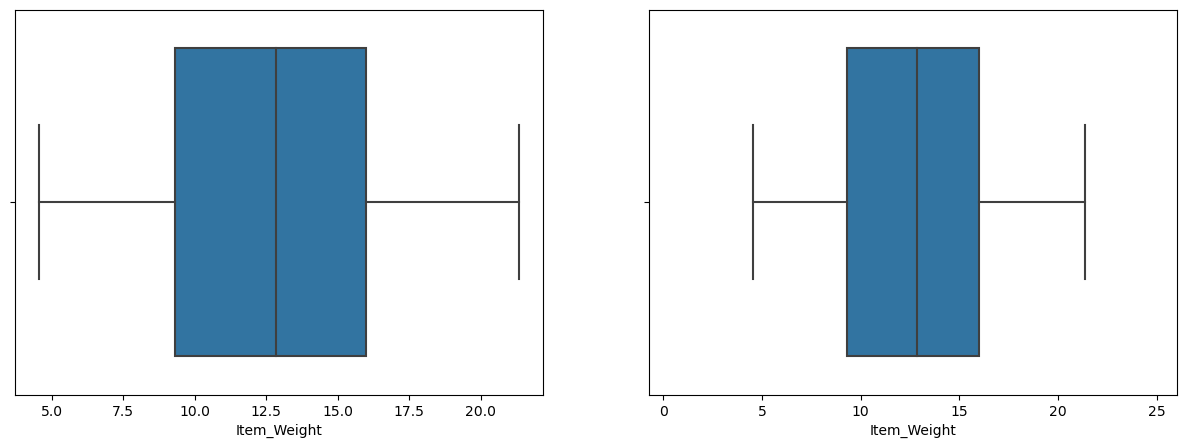

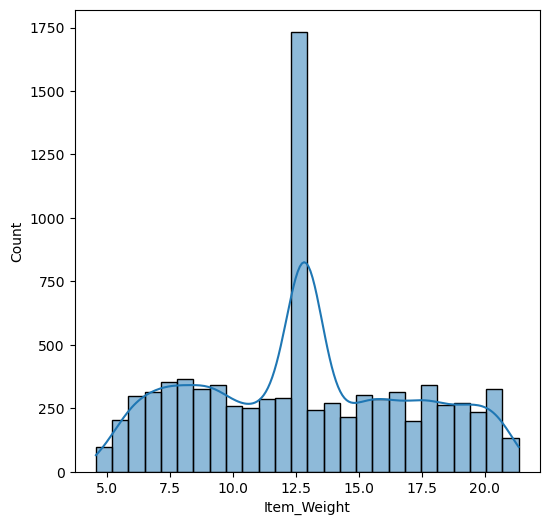

In [26]:
diagrama_caixa(train['Item_Weight'])
histograma(train['Item_Weight'])


É visto que o grande parte dos produtos possuem um peso de 12.5kg

## Item_Visibility

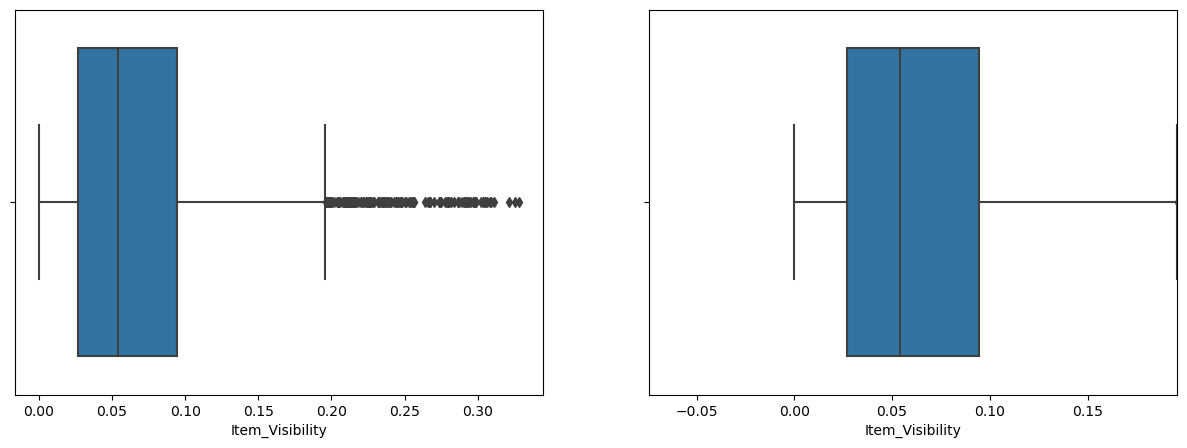

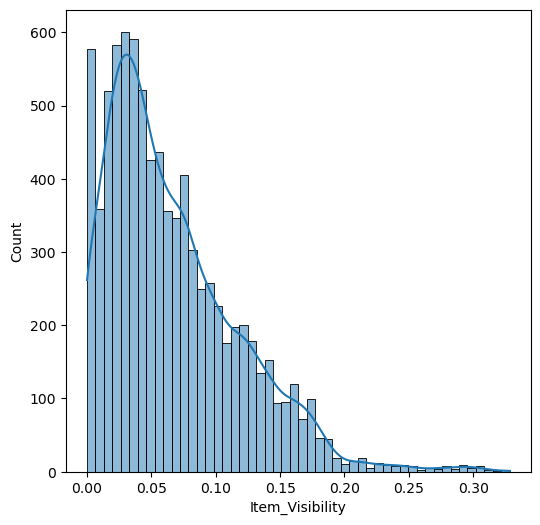

In [27]:
diagrama_caixa(train['Item_Visibility'])
histograma(train['Item_Visibility'])

144 linhas removidas.


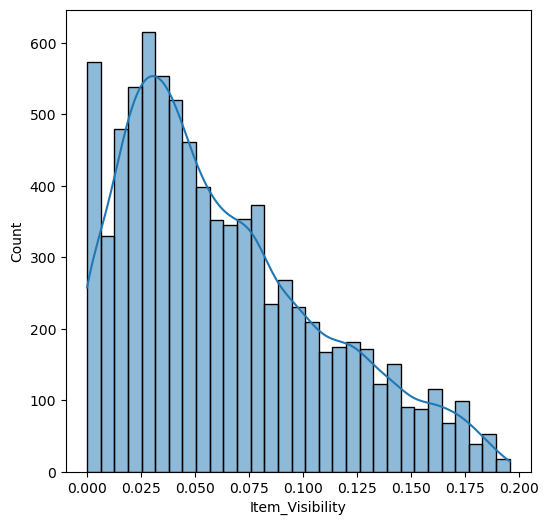

In [28]:
train, linhas_removidas = excluir_outliers(train, 'Item_Visibility')
print('{} linhas removidas.'.format(linhas_removidas))
train.shape

histograma(train['Item_Visibility'])

## Item_MRP

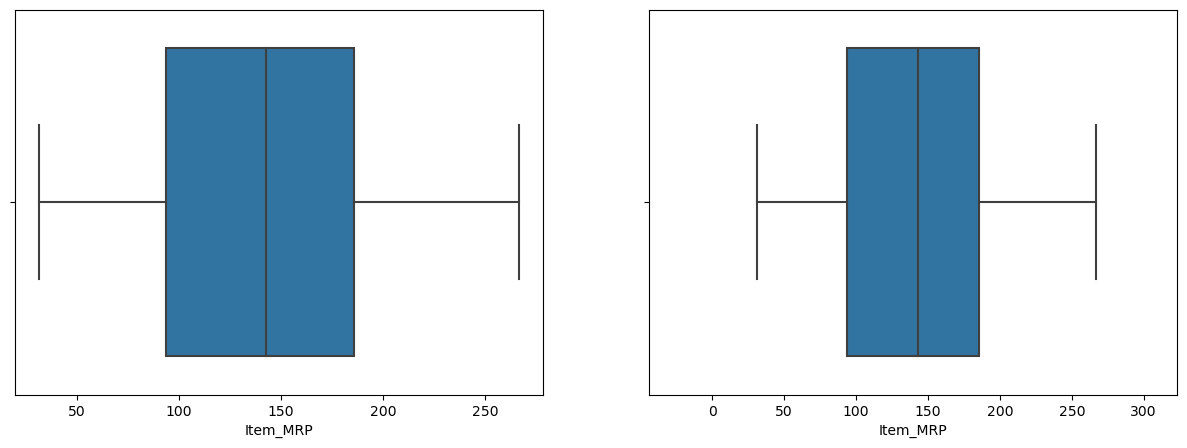

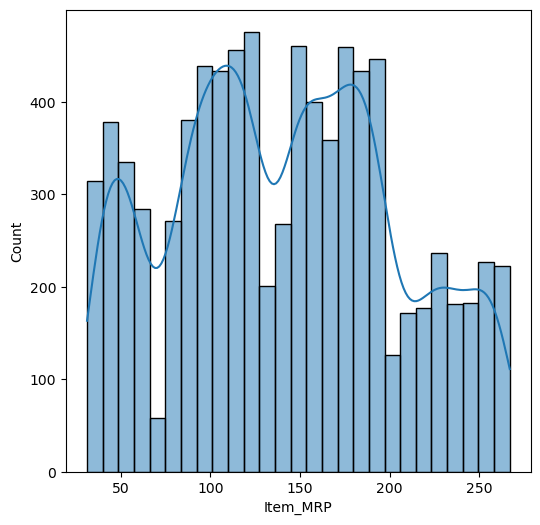

In [29]:
diagrama_caixa(train['Item_MRP'])
histograma(train['Item_MRP'])

## Outlet_Establishment_Year

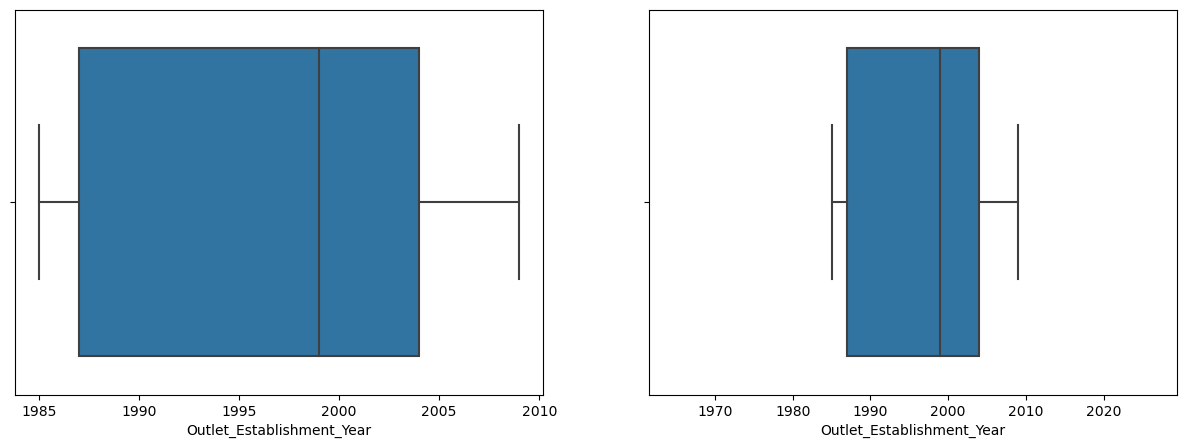

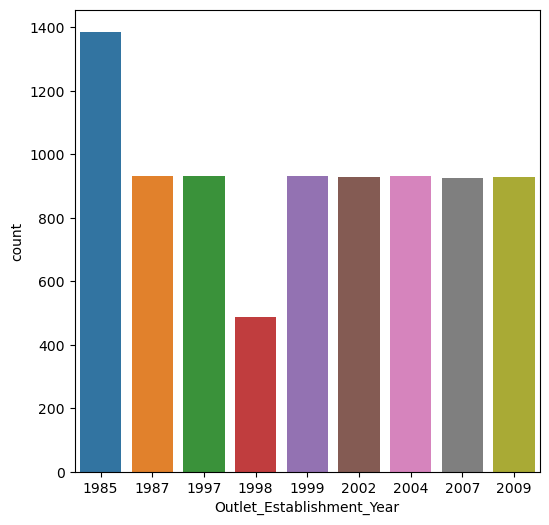

In [30]:
diagrama_caixa(train['Outlet_Establishment_Year'])
countplot(train['Outlet_Establishment_Year'])

## Item_Outlet_Sales

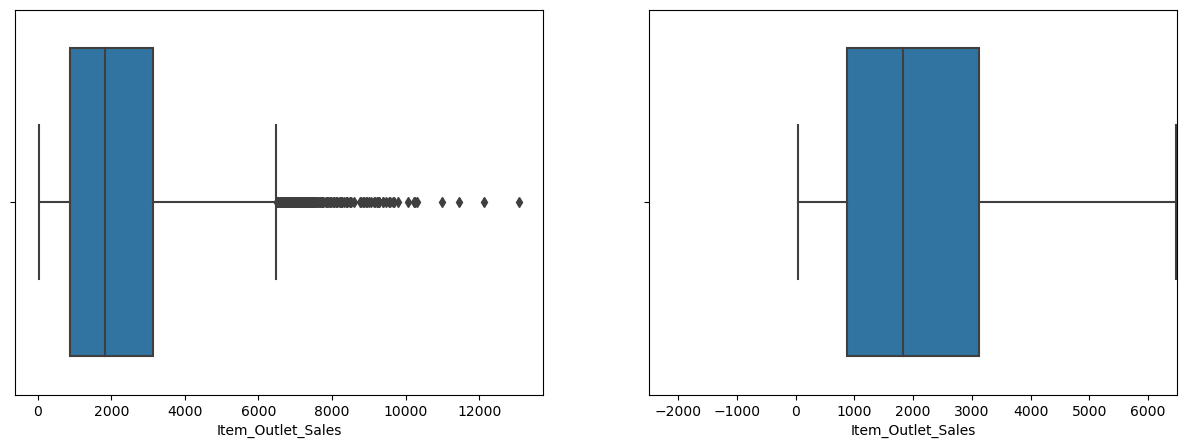

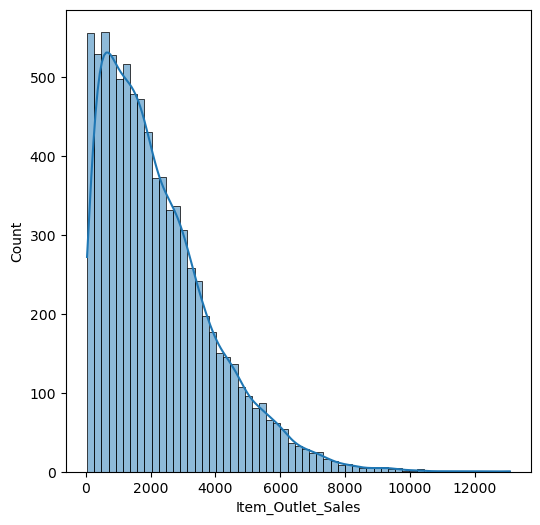

In [31]:
diagrama_caixa(train['Item_Outlet_Sales'])
histograma(train['Item_Outlet_Sales'])

186 linhas removidas.


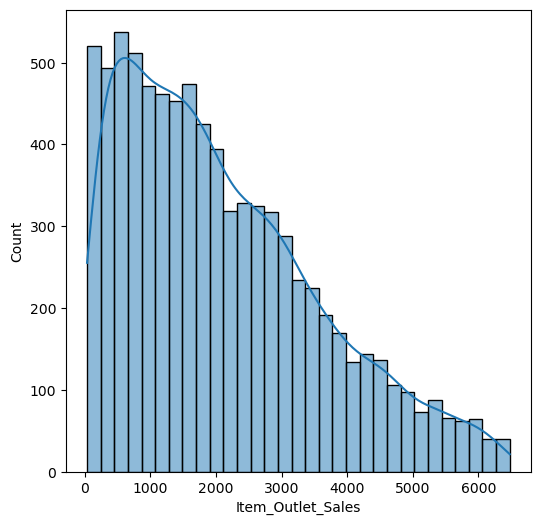

In [32]:
train, linhas_removidas = excluir_outliers(train, 'Item_Outlet_Sales')
print('{} linhas removidas.'.format(linhas_removidas))
train.shape

histograma(train['Item_Outlet_Sales'])

#train=train[train['Item_Outlet_Sales']<6250]


# Valores Texto

In [33]:
valores_texto = train.select_dtypes(include=['object']).columns.tolist()
valores_texto

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

## Item_Identifier

In [34]:
train['Item_Identifier'].str[0:2].value_counts()

FD    5870
NC    1551
DR     772
Name: Item_Identifier, dtype: int64

FD provavelmente FOOD;\
NC provavelmente NON-CONSUMABLES;\
DR provavelmente DRINKS;

Vou criar uma nova tabela

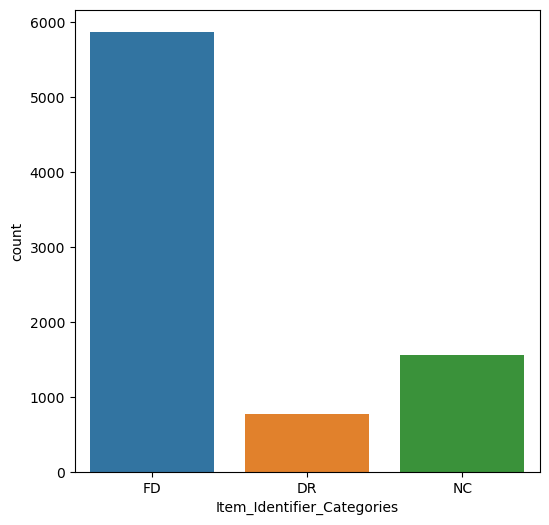

In [35]:
train['Item_Identifier_Categories'] = train['Item_Identifier'].str[0:2]
countplot(train['Item_Identifier_Categories'])

## Item_Fat_Content

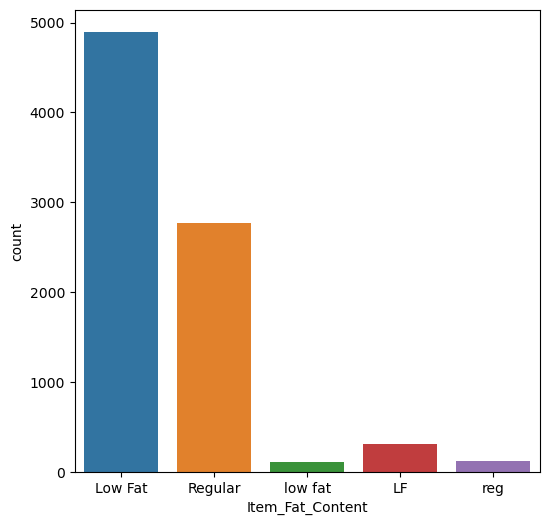

In [36]:
countplot(train['Item_Fat_Content'])

"Low Fat" e "Regular" estão duplicados, o que podemos fazer é juntá-los para simplificar o nosso modelo de previsão.

Low Fat    5309
Regular    2884
Name: Item_Fat_Content, dtype: int64

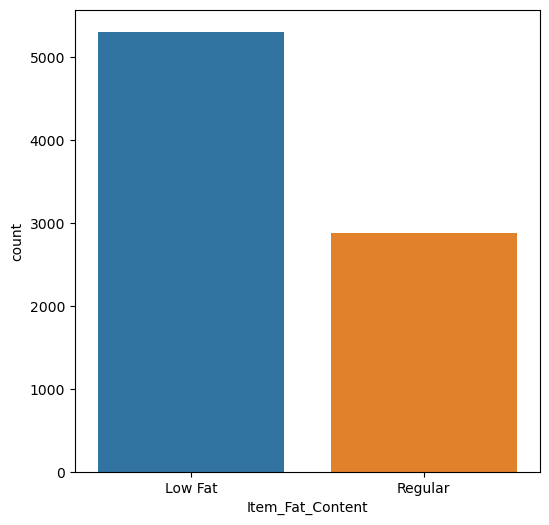

In [37]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace('low fat', 'Low Fat')
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace('LF', 'Low Fat')
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace('reg', 'Regular')

countplot(train['Item_Fat_Content'])

train['Item_Fat_Content'].value_counts()

## Item_Type


Fruits and Vegetables    1175
Snack Foods              1154
Household                 877
Frozen Foods              830
Dairy                     649
Canned                    626
Baking Goods              622
Health and Hygiene        507
Soft Drinks               428
Meat                      409
Breads                    242
Hard Drinks               207
Others                    167
Starchy Foods             139
Breakfast                 101
Seafood                    60
Name: Item_Type, dtype: int64


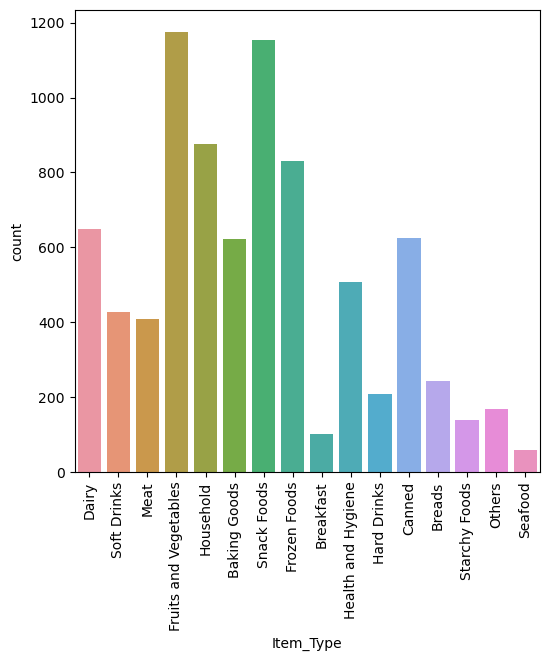

In [38]:
plt.figure(figsize=(6, 6))
grafico = sns.countplot(data=train, x=train['Item_Type'])
grafico.tick_params(axis='x', rotation=90)

print(train['Item_Type'].value_counts())

## Outlet_Identifier

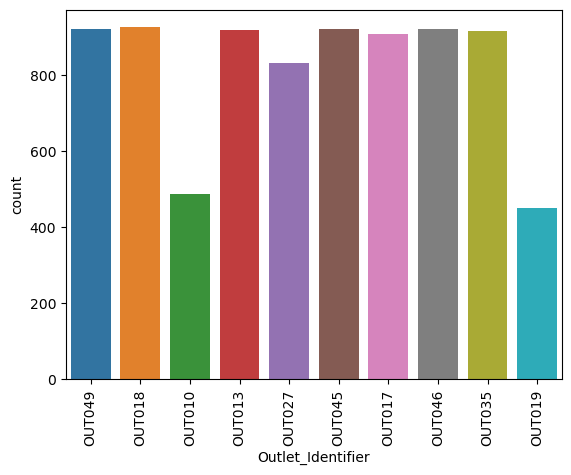

In [39]:
grafico = sns.countplot(data=train, x=train['Outlet_Identifier'])
grafico.tick_params(axis='x', rotation=90)

## Outlet_Size

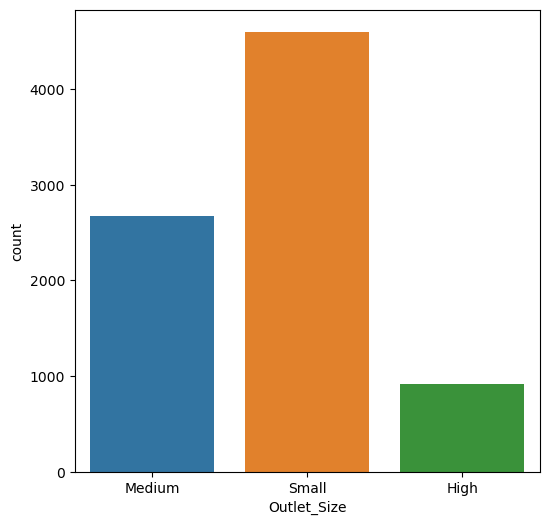

In [40]:
countplot(train['Outlet_Size'])

## Outlet_Location_Type

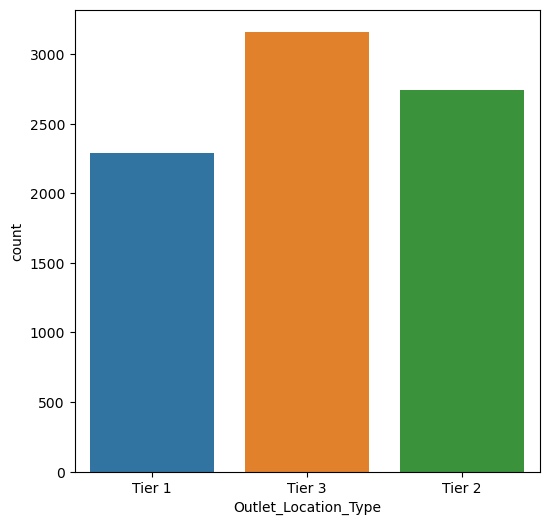

In [41]:
countplot(train['Outlet_Location_Type'])

## Outlet_Type

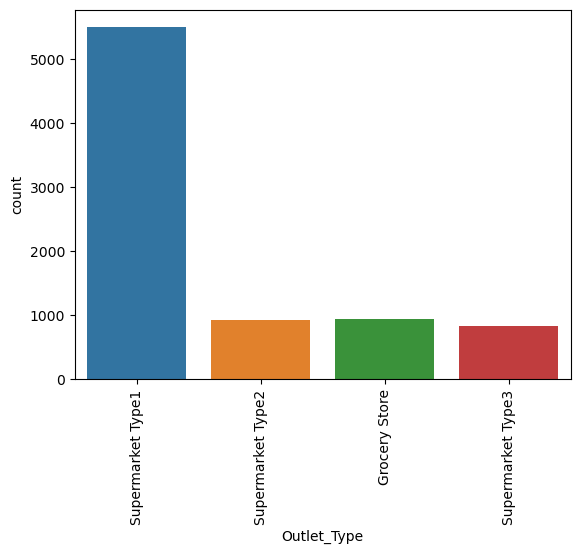

In [42]:
grafico = sns.countplot(data=train, x=train['Outlet_Type'])
grafico.tick_params(axis='x', rotation=90)

## Outlet_Establishment_Year

In [43]:
train['Outlet_Age'] = 2023-train['Outlet_Establishment_Year'] 
train = train.drop('Outlet_Establishment_Year', axis=1)
train.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Identifier_Categories,Outlet_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,FD,24
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,DR,14
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,FD,24


In [44]:
train['Outlet_Age'] = train['Outlet_Age'].astype(np.int32)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8193 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Item_Identifier             8193 non-null   object 
 1   Item_Weight                 8193 non-null   float64
 2   Item_Fat_Content            8193 non-null   object 
 3   Item_Visibility             8193 non-null   float64
 4   Item_Type                   8193 non-null   object 
 5   Item_MRP                    8193 non-null   float64
 6   Outlet_Identifier           8193 non-null   object 
 7   Outlet_Size                 8193 non-null   object 
 8   Outlet_Location_Type        8193 non-null   object 
 9   Outlet_Type                 8193 non-null   object 
 10  Item_Outlet_Sales           8193 non-null   float64
 11  Item_Identifier_Categories  8193 non-null   object 
 12  Outlet_Age                  8193 non-null   int32  
dtypes: float64(4), int32(1), object(8

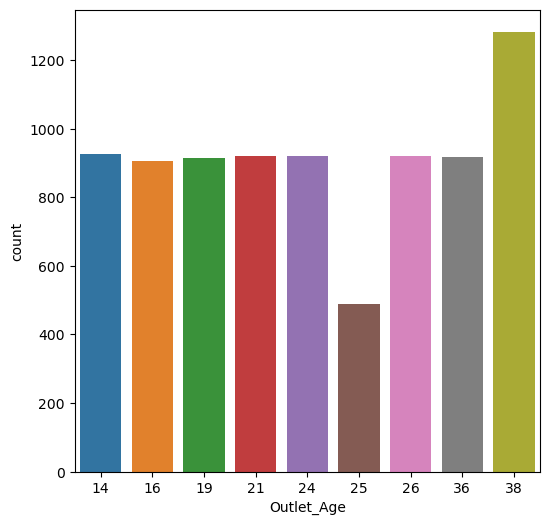

In [45]:
countplot(train['Outlet_Age'])

## Relações

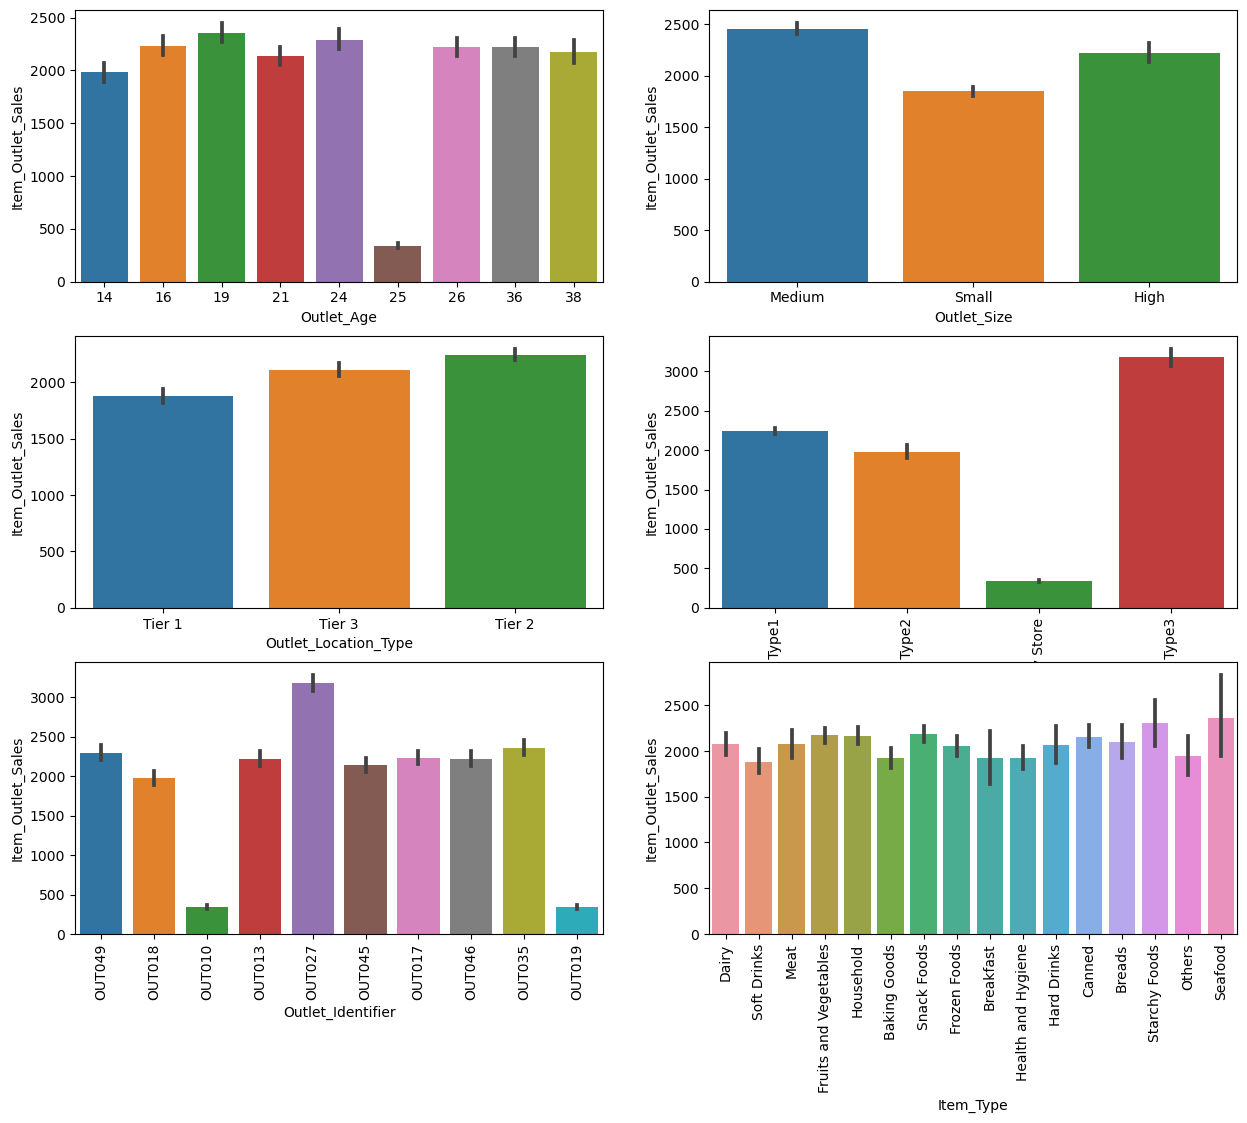

In [46]:
fig, axes = plt.subplots(3,2,figsize=(15,12))
grafico = sns.barplot(x='Outlet_Age',y='Item_Outlet_Sales',ax=axes[0,0],data=train)
grafico = sns.barplot(x='Outlet_Size',y='Item_Outlet_Sales',ax=axes[0,1],data=train)
grafico = sns.barplot(x='Outlet_Location_Type',y='Item_Outlet_Sales',ax=axes[1,0],data=train)
grafico = sns.barplot(x='Outlet_Type',y='Item_Outlet_Sales',ax=axes[1,1],data=train)
grafico.tick_params(axis='x', rotation=90)
grafico = sns.barplot(x='Outlet_Identifier', y='Item_Outlet_Sales', ax=axes[2,0], data=train)
grafico.tick_params(axis='x', rotation=90)
grafico = sns.barplot(x='Item_Type', y='Item_Outlet_Sales', ax=axes[2,1], data=train)
grafico.tick_params(axis='x', rotation=90)

In [47]:
train.shape

(8193, 13)

In [48]:
train.iloc[0]

Item_Identifier                           FDA15
Item_Weight                                 9.3
Item_Fat_Content                        Low Fat
Item_Visibility                        0.016047
Item_Type                                 Dairy
Item_MRP                               249.8092
Outlet_Identifier                        OUT049
Outlet_Size                              Medium
Outlet_Location_Type                     Tier 1
Outlet_Type                   Supermarket Type1
Item_Outlet_Sales                      3735.138
Item_Identifier_Categories                   FD
Outlet_Age                                   24
Name: 0, dtype: object

# Encoding
# Label Encoding

## Outlet_Size

In [49]:
train['Outlet_Size'].value_counts()

Small     4600
Medium    2676
High       917
Name: Outlet_Size, dtype: int64

In [50]:
train['Outlet_Size'] = train['Outlet_Size'].map({'Small': 1, 
                                                'Medium': 2,
                                                'High': 3
                                                }).astype(int)

In [51]:
train.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Identifier_Categories,Outlet_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,2,Tier 1,Supermarket Type1,3735.1380,FD,24
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2,Tier 3,Supermarket Type2,443.4228,DR,14
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,2,Tier 1,Supermarket Type1,2097.2700,FD,24


## Item_Fat_Content

In [52]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].map({'Low Fat':1, 'Regular':0})

In [53]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].astype(np.int32)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8193 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Item_Identifier             8193 non-null   object 
 1   Item_Weight                 8193 non-null   float64
 2   Item_Fat_Content            8193 non-null   int32  
 3   Item_Visibility             8193 non-null   float64
 4   Item_Type                   8193 non-null   object 
 5   Item_MRP                    8193 non-null   float64
 6   Outlet_Identifier           8193 non-null   object 
 7   Outlet_Size                 8193 non-null   int32  
 8   Outlet_Location_Type        8193 non-null   object 
 9   Outlet_Type                 8193 non-null   object 
 10  Item_Outlet_Sales           8193 non-null   float64
 11  Item_Identifier_Categories  8193 non-null   object 
 12  Outlet_Age                  8193 non-null   int32  
dtypes: float64(4), int32(3), object(6

In [54]:
train.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Identifier_Categories,Outlet_Age
0,FDA15,9.30,1,0.016047,Dairy,249.8092,OUT049,2,Tier 1,Supermarket Type1,3735.1380,FD,24
1,DRC01,5.92,0,0.019278,Soft Drinks,48.2692,OUT018,2,Tier 3,Supermarket Type2,443.4228,DR,14
2,FDN15,17.50,1,0.016760,Meat,141.6180,OUT049,2,Tier 1,Supermarket Type1,2097.2700,FD,24


# One Hot Encoding (Dummies)

## Outlet_Location_Type

In [55]:
train['Outlet_Type'].value_counts()

Supermarket Type1    5497
Grocery Store         939
Supermarket Type2     925
Supermarket Type3     832
Name: Outlet_Type, dtype: int64

In [56]:
print(train.shape) #Antes tinha apenas 12 colunas, agora tem 13.
train.head(3)

(8193, 13)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Identifier_Categories,Outlet_Age
0,FDA15,9.30,1,0.016047,Dairy,249.8092,OUT049,2,Tier 1,Supermarket Type1,3735.1380,FD,24
1,DRC01,5.92,0,0.019278,Soft Drinks,48.2692,OUT018,2,Tier 3,Supermarket Type2,443.4228,DR,14
2,FDN15,17.50,1,0.016760,Meat,141.6180,OUT049,2,Tier 1,Supermarket Type1,2097.2700,FD,24


In [57]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8193 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Item_Identifier             8193 non-null   object 
 1   Item_Weight                 8193 non-null   float64
 2   Item_Fat_Content            8193 non-null   int32  
 3   Item_Visibility             8193 non-null   float64
 4   Item_Type                   8193 non-null   object 
 5   Item_MRP                    8193 non-null   float64
 6   Outlet_Identifier           8193 non-null   object 
 7   Outlet_Size                 8193 non-null   int32  
 8   Outlet_Location_Type        8193 non-null   object 
 9   Outlet_Type                 8193 non-null   object 
 10  Item_Outlet_Sales           8193 non-null   float64
 11  Item_Identifier_Categories  8193 non-null   object 
 12  Outlet_Age                  8193 non-null   int32  
dtypes: float64(4), int32(3), object(6

In [58]:
train = pd.get_dummies(data=train, columns=['Item_Type', 'Outlet_Identifier', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Identifier_Categories'], drop_first=True)
train.head(3)
print(train.shape)

(8193, 39)


In [59]:
train.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Item_Outlet_Sales,Outlet_Age,Item_Type_Breads,Item_Type_Breakfast,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Identifier_Categories_FD,Item_Identifier_Categories_NC
0,FDA15,9.30,1,0.016047,249.8092,2,3735.1380,24,0,0,...,0,0,1,0,0,1,0,0,1,0
1,DRC01,5.92,0,0.019278,48.2692,2,443.4228,14,0,0,...,0,0,0,0,1,0,1,0,0,0
2,FDN15,17.50,1,0.016760,141.6180,2,2097.2700,24,0,0,...,0,0,1,0,0,1,0,0,1,0


# Test

In [60]:
test.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.75,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.30,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.60,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store


In [61]:
test.shape

(5681, 11)

In [62]:
test.info()
print('-'*60)
test.iloc[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB
------------------------------------------------------------


Item_Identifier                          FDW58
Item_Weight                              20.75
Item_Fat_Content                       Low Fat
Item_Visibility                       0.007565
Item_Type                          Snack Foods
Item_MRP                              107.8622
Outlet_Identifier                       OUT049
Outlet_Establishment_Year                 1999
Outlet_Size                             Medium
Outlet_Location_Type                    Tier 1
Outlet_Type                  Supermarket Type1
Name: 0, dtype: object

# Tratanto valores vazios

In [63]:
test.isnull().sum().sort_values(ascending=False)

Outlet_Size                  1606
Item_Weight                   976
Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

## Outlet_Size

In [64]:
test['Outlet_Size'].mode()[0]

'Medium'

In [65]:
test['Outlet_Size'].fillna(test.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.mode()[0]), inplace=True)
test.isnull().sum().sort_values(ascending=False)

Item_Weight                  976
Item_Identifier                0
Item_Fat_Content               0
Item_Visibility                0
Item_Type                      0
Item_MRP                       0
Outlet_Identifier              0
Outlet_Establishment_Year      0
Outlet_Size                    0
Outlet_Location_Type           0
Outlet_Type                    0
dtype: int64

## Item_Weight

In [66]:
test.loc[test.Item_Weight.isnull(), 'Item_Weight'] = test.Item_Weight.mean()
test.isnull().sum().sort_values(ascending=False)

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

# Feature Engineering

## Valores numéricos

In [67]:
colunas_numericas = test.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(colunas_numericas)

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']


## Item_Weight

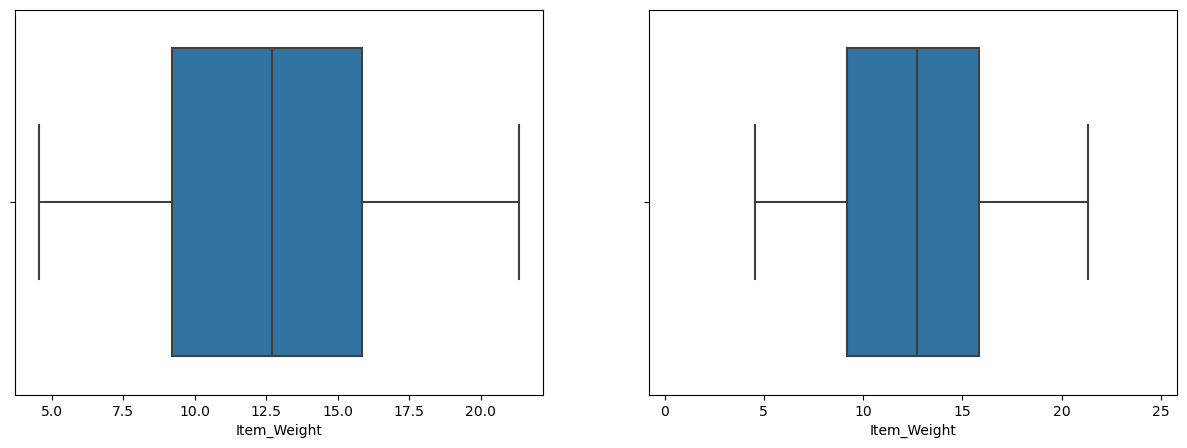

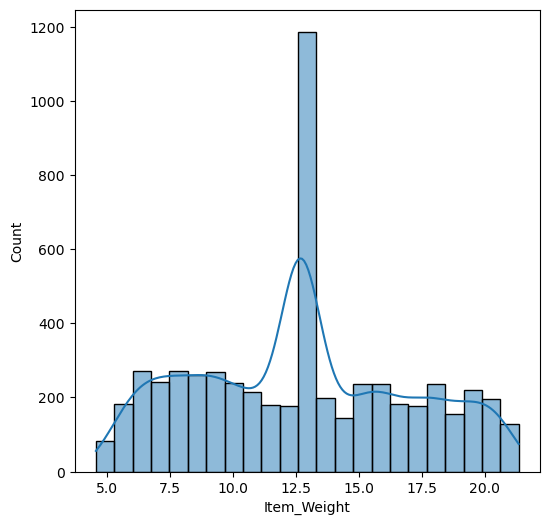

In [68]:
diagrama_caixa(test['Item_Weight'])
histograma(test['Item_Weight'])

## Item_Visibility

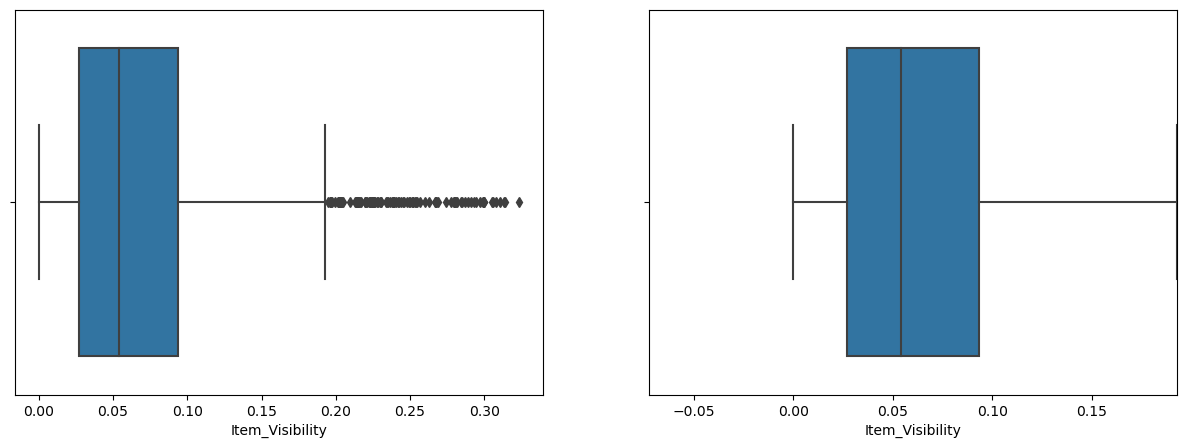

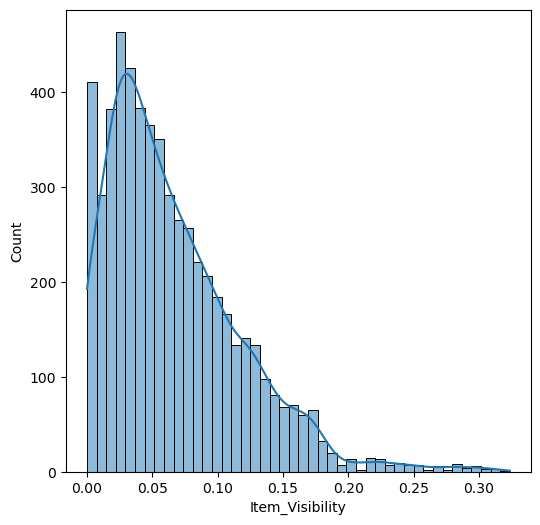

In [69]:
diagrama_caixa(test['Item_Visibility'])
histograma(test['Item_Visibility'])

113 linhas removidas.


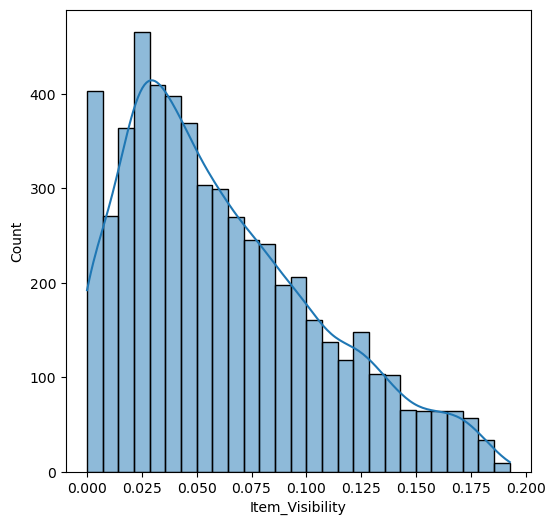

In [70]:
test, linhas_removidas = excluir_outliers(test, 'Item_Visibility')
print('{} linhas removidas.'.format(linhas_removidas))
test.shape

histograma(test['Item_Visibility'])

## Outlet_Establishment_Year

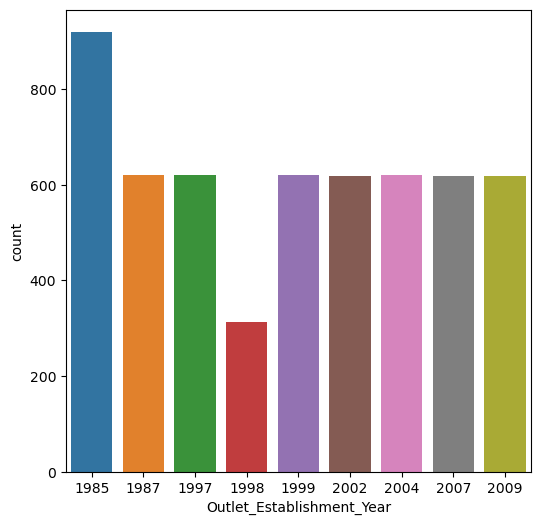

In [71]:
countplot(test['Outlet_Establishment_Year'])

In [72]:
test_copy = test.copy()

In [73]:
test_copy.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.75,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.30,reg,0.038428,Dairy,87.3198,OUT017,2007,Small,Tier 2,Supermarket Type1
2,NCN55,14.60,Low Fat,0.099575,Others,241.7538,OUT010,1998,Small,Tier 3,Grocery Store


In [74]:
test_copy['Outlet_Age'] = 2023-test_copy['Outlet_Establishment_Year'] 
test_copy = test_copy.drop('Outlet_Establishment_Year', axis=1)
test_copy.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Age
0,FDW58,20.75,Low Fat,0.007565,Snack Foods,107.8622,OUT049,Medium,Tier 1,Supermarket Type1,24
1,FDW14,8.30,reg,0.038428,Dairy,87.3198,OUT017,Small,Tier 2,Supermarket Type1,16
2,NCN55,14.60,Low Fat,0.099575,Others,241.7538,OUT010,Small,Tier 3,Grocery Store,25


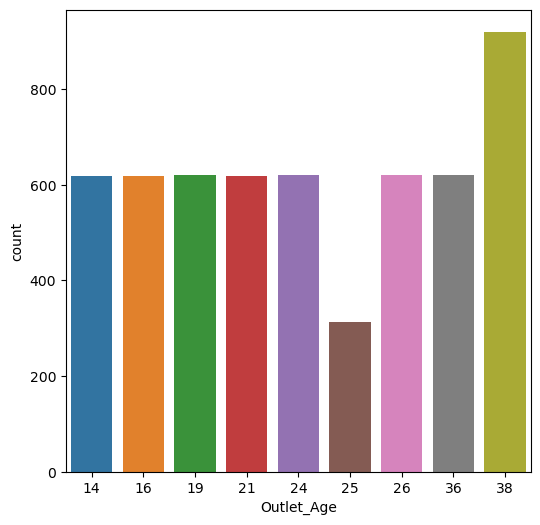

In [75]:
test_copy['Outlet_Age'] = test_copy['Outlet_Age'].astype(np.int32)
countplot(test_copy['Outlet_Age'])

## Valores de Texto

In [76]:
colunas_texto = test.select_dtypes(include='object').columns.tolist()
print(colunas_texto)

['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


## Item_Identifier

In [77]:
test_copy['Item_Identifier'].str[0:2].value_counts()

FD    3983
NC    1074
DR     511
Name: Item_Identifier, dtype: int64

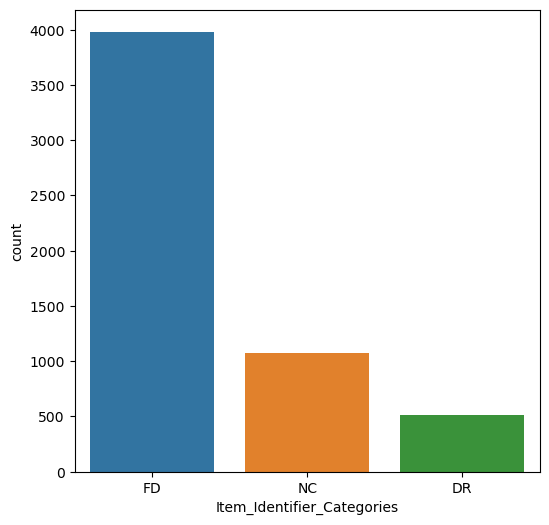

In [78]:
test_copy['Item_Identifier_Categories'] = test_copy['Item_Identifier'].str[0:2]
countplot(test_copy['Item_Identifier_Categories'])

In [79]:
test_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5568 entries, 0 to 5680
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Item_Identifier             5568 non-null   object 
 1   Item_Weight                 5568 non-null   float64
 2   Item_Fat_Content            5568 non-null   object 
 3   Item_Visibility             5568 non-null   float64
 4   Item_Type                   5568 non-null   object 
 5   Item_MRP                    5568 non-null   float64
 6   Outlet_Identifier           5568 non-null   object 
 7   Outlet_Size                 5568 non-null   object 
 8   Outlet_Location_Type        5568 non-null   object 
 9   Outlet_Type                 5568 non-null   object 
 10  Outlet_Age                  5568 non-null   int32  
 11  Item_Identifier_Categories  5568 non-null   object 
dtypes: float64(3), int32(1), object(8)
memory usage: 543.8+ KB


## Item_Fat_Content

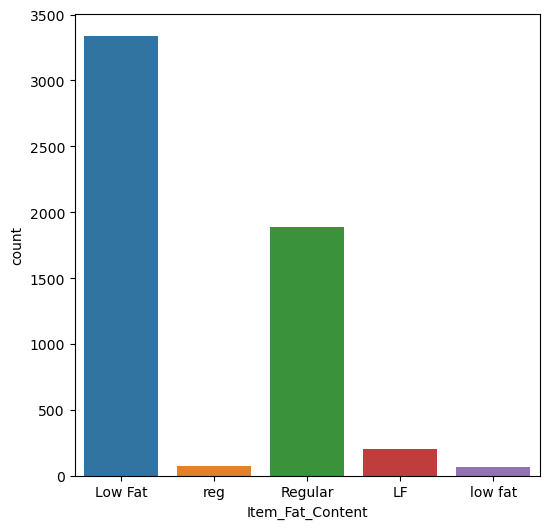

In [80]:
test_copy['Item_Fat_Content'].value_counts()
countplot(test_copy['Item_Fat_Content'])

Low Fat    3604
Regular    1964
Name: Item_Fat_Content, dtype: int64

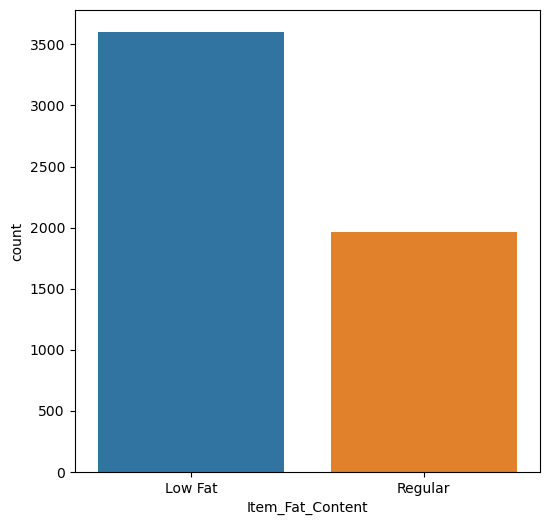

In [81]:
test_copy['Item_Fat_Content'] = test_copy['Item_Fat_Content'].replace(['low fat', 'LF'], 'Low Fat')
test_copy['Item_Fat_Content'] = test_copy['Item_Fat_Content'].replace('reg', 'Regular')

countplot(test_copy['Item_Fat_Content'])

display(test_copy['Item_Fat_Content'].value_counts())

# Encoding

In [82]:
test_copy.iloc[0]

Item_Identifier                           FDW58
Item_Weight                               20.75
Item_Fat_Content                        Low Fat
Item_Visibility                        0.007565
Item_Type                           Snack Foods
Item_MRP                               107.8622
Outlet_Identifier                        OUT049
Outlet_Size                              Medium
Outlet_Location_Type                     Tier 1
Outlet_Type                   Supermarket Type1
Outlet_Age                                   24
Item_Identifier_Categories                   FD
Name: 0, dtype: object

In [83]:
test.shape

(5568, 11)

In [84]:
test_copy.shape

(5568, 12)

# Label Encoding

- Item_Fat_Content
- Outlet_Size

## Item_Fat_Content

In [85]:
test_copy['Item_Fat_Content'] = test_copy['Item_Fat_Content'].map({'Low Fat': 1, 'Regular': 0})
test_copy['Item_Fat_Content'] = test_copy['Item_Fat_Content'].astype(np.int32)
print(test_copy.info())
test_copy.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5568 entries, 0 to 5680
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Item_Identifier             5568 non-null   object 
 1   Item_Weight                 5568 non-null   float64
 2   Item_Fat_Content            5568 non-null   int32  
 3   Item_Visibility             5568 non-null   float64
 4   Item_Type                   5568 non-null   object 
 5   Item_MRP                    5568 non-null   float64
 6   Outlet_Identifier           5568 non-null   object 
 7   Outlet_Size                 5568 non-null   object 
 8   Outlet_Location_Type        5568 non-null   object 
 9   Outlet_Type                 5568 non-null   object 
 10  Outlet_Age                  5568 non-null   int32  
 11  Item_Identifier_Categories  5568 non-null   object 
dtypes: float64(3), int32(2), object(7)
memory usage: 522.0+ KB
None


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Age,Item_Identifier_Categories
0,FDW58,20.75,1,0.007565,Snack Foods,107.8622,OUT049,Medium,Tier 1,Supermarket Type1,24,FD
1,FDW14,8.30,0,0.038428,Dairy,87.3198,OUT017,Small,Tier 2,Supermarket Type1,16,FD
2,NCN55,14.60,1,0.099575,Others,241.7538,OUT010,Small,Tier 3,Grocery Store,25,NC


## Outlet_Size

In [86]:
test_copy['Outlet_Size'] = test_copy['Outlet_Size'].map({'Small': 1,
                                              'Medium': 2,
                                              'High': 3
                                              }).astype(int)
test_copy.head(7)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Age,Item_Identifier_Categories
0,FDW58,20.750000,1,0.007565,Snack Foods,107.8622,OUT049,2,Tier 1,Supermarket Type1,24,FD
1,FDW14,8.300000,0,0.038428,Dairy,87.3198,OUT017,1,Tier 2,Supermarket Type1,16,FD
2,NCN55,14.600000,1,0.099575,Others,241.7538,OUT010,1,Tier 3,Grocery Store,25,NC
3,FDQ58,7.315000,1,0.015388,Snack Foods,155.0340,OUT017,1,Tier 2,Supermarket Type1,16,FD
4,FDY38,12.695633,0,0.118599,Dairy,234.2300,OUT027,2,Tier 3,Supermarket Type3,38,FD
5,FDH56,9.800000,0,0.063817,Fruits and Vegetables,117.1492,OUT046,1,Tier 1,Supermarket Type1,26,FD
6,FDL48,19.350000,0,0.082602,Baking Goods,50.1034,OUT018,2,Tier 3,Supermarket Type2,14,FD


In [87]:
test_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5568 entries, 0 to 5680
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Item_Identifier             5568 non-null   object 
 1   Item_Weight                 5568 non-null   float64
 2   Item_Fat_Content            5568 non-null   int32  
 3   Item_Visibility             5568 non-null   float64
 4   Item_Type                   5568 non-null   object 
 5   Item_MRP                    5568 non-null   float64
 6   Outlet_Identifier           5568 non-null   object 
 7   Outlet_Size                 5568 non-null   int32  
 8   Outlet_Location_Type        5568 non-null   object 
 9   Outlet_Type                 5568 non-null   object 
 10  Outlet_Age                  5568 non-null   int32  
 11  Item_Identifier_Categories  5568 non-null   object 
dtypes: float64(3), int32(3), object(6)
memory usage: 500.2+ KB


## One Hot Encoding

- Item_Type
- Outlet_Identifier
- Outlet_Location_Type
- Outlet_Type
- Item_Identifier_Categories

In [88]:
test_copy = pd.get_dummies(data=test_copy, columns=['Item_Type', 'Outlet_Identifier', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Identifier_Categories'], drop_first=True)
test_copy.head(3)
print(test_copy.shape)

(5568, 38)


In [89]:
test_copy.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Age,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Identifier_Categories_FD,Item_Identifier_Categories_NC
0,FDW58,20.75,1,0.007565,107.8622,2,24,0,0,0,...,0,0,1,0,0,1,0,0,1,0
1,FDW14,8.30,0,0.038428,87.3198,1,16,0,0,0,...,0,0,0,1,0,1,0,0,1,0
2,NCN55,14.60,1,0.099575,241.7538,1,25,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [90]:
train.drop(labels=['Item_Identifier'], axis=1, inplace=True)
test_copy.drop(labels=['Item_Identifier'],  axis=1, inplace=True)

In [91]:
print(train.shape)
print(test_copy.shape)

(8193, 38)
(5568, 37)


## Diferença entre Pandas Get Dummies & Label Encoding
- É que o Label encoding vai ocupar menos espaço e vai enumerar os valores, vai transformá-los em Integers.\
    Assim, por exemplo: paris, paris, tokyo, roma
    [0      0      1     2]
    
    O problema é que o nosso modelo, o algoritmo pode enxergar que a ordem tenha alguma importância, paris é mais próximo de tokyo do que roma? Roma por ser 2 é mais distante...
    
- Já o pd Get Dummies ele vai evitar isso, com 0 e 1, mas irá ocupar mais espaço.
                          

# Modelo de Previsão

testes: 
- Ver se eu consigo prencher os valores vazios de Outlet_Size realcionando com Outlet_Type 
1. tudo com pd.get_dummies 
2. só Outlet_Identifier com label encoding
3. tudo com label encoding

## Métricas de Avaliação
1. R²: Quanto das informações ele consegue explicar
2. Raíz de Erro Quadrático Médio (RSME): ele desconta os error mais drásticos

## Modelos
1. Random Forest
2. Linear Regression
3. Extra Trees


In [92]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    
    return f'Modelo {nome_modelo}:\nR²: {r2:.2%}\nRSME: {RSME:.2f}'

In [93]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
         'LinearRegression': modelo_lr,
         'ExtraTrees': modelo_et,
         }

y = train['Item_Outlet_Sales']
X = train.drop('Item_Outlet_Sales', axis=1)

In [94]:
X.shape

(8193, 37)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
for nome_modelo, modelo in modelos.items():
    # treinar
    modelo.fit(X_train, y_train)
    # testar
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²: 53.25%
RSME: 1033.94
Modelo LinearRegression:
R²: 55.88%
RSME: 1004.43
Modelo ExtraTrees:
R²: 49.58%
RSME: 1073.73


- O melhor modelo foi o LinearRegression com R² de 55.88% e RSME de 1004.43. Vamos ver se conseguimos melhorar o desempenho do nosso modelo. Vou tentar adicionar polynomial features para ver quão bem o Linear Regression performa. 

In [96]:
steps = [
    ('scaler', StandardScaler()),
    ('poly',   PolynomialFeatures(degree=2)),
    ('model',  LinearRegression())
       ]

lin_reg_pipeline = Pipeline(steps)

lin_reg_pipeline.fit(X_train, y_train)

print('Training score  : {}'.format(lin_reg_pipeline.score(X_train, y_train)))
print('Test score      : {}'.format(lin_reg_pipeline.score(X_test, y_test)))

Training score  : 0.5926448839108674
Test score      : 0.5696348953230136


- O Training score está 0.59 enquanto o Test score está 0.56, aqui temos o problema de overfiting de data. Se aumentarmos o PolynomialFeatures só vai piorar. Vamos regularizar o nosso modelo Linear Regression então, com os chamados:
    - Lasso Regression (1 Regularization)
    - Ridge Regression (2 Regularization) 

## Lasso Regression

In [97]:
steps = [
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2)),
            ('model', Lasso(alpha=0.2, fit_intercept=True))
        ]

lasso_pipeline = Pipeline(steps)

lasso_pipeline.fit(X_train, y_train)

print('Training score  : {}'    .format(lasso_pipeline.score(X_train, y_train)))
print('Test score      : {}'    .format(lasso_pipeline.score(X_test, y_test)))

Training score  : 0.598276674519477
Test score      : 0.5761835981930563


C:\Users\akyan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.793e+08, tolerance: 1.378e+06
  model = cd_fast.enet_coordinate_descent(


In [98]:
lasso_predictions = lasso_pipeline.predict(X_test)

In [99]:
lasso_r2 = r2_score(y_test, lasso_predictions)
lasso_rsme = np.sqrt(mean_squared_error(y_test, lasso_predictions))
print('Lasso R² score: {}'.format(lasso_r2))
print('Lasso RSME score: {}'.format(lasso_rsme))

Lasso R² score: 0.5761835981930563
Lasso RSME score: 984.4062659408


- Podemos ver que a regularização melhorou o nosso modelo de previsão, de 0.56 passou para 0.57. 

## Ridge Regression

In [100]:
steps = [
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2)),
            ('model', Ridge(alpha=7, fit_intercept=True))
        ]

ridge_pipeline = Pipeline(steps)
ridge_pipeline.fit(X_train, y_train)

print('Training score: {}'.format(ridge_pipeline.score(X_train, y_train)))
print('Training score: {}'.format(ridge_pipeline.score(X_test, y_test)))

Training score: 0.5983221551242222
Training score: 0.5756408740250014


In [101]:
ridge_predictions = ridge_pipeline.predict(X_test)

In [102]:
ridge_r2 = r2_score(y_test, ridge_predictions)
ridge_rsme = np.sqrt(mean_squared_error(y_test, ridge_predictions))
print('Ridge R² score: {}'.format(ridge_r2))
print('Ridge RSME score: {}'.format(ridge_rsme))

Ridge R² score: 0.5756408740250014
Ridge RSME score: 985.0363620625417


- Resultado: O Lasso Regression obteve melhores resultados, portanto, vou optar por este regularizador.

# Final - Base para envio 

### Submission file format
Variable Description\
Item_Identifier ----- Unique product ID\
Outlet_Identifier ----- Unique store ID\
Item_Outlet_Sales ----- Sales of the product in t particular store. This is the outcome variable to be predicted.

In [103]:
test_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5568 entries, 0 to 5680
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Weight                      5568 non-null   float64
 1   Item_Fat_Content                 5568 non-null   int32  
 2   Item_Visibility                  5568 non-null   float64
 3   Item_MRP                         5568 non-null   float64
 4   Outlet_Size                      5568 non-null   int32  
 5   Outlet_Age                       5568 non-null   int32  
 6   Item_Type_Breads                 5568 non-null   uint8  
 7   Item_Type_Breakfast              5568 non-null   uint8  
 8   Item_Type_Canned                 5568 non-null   uint8  
 9   Item_Type_Dairy                  5568 non-null   uint8  
 10  Item_Type_Frozen Foods           5568 non-null   uint8  
 11  Item_Type_Fruits and Vegetables  5568 non-null   uint8  
 12  Item_Type_Hard Drink

In [104]:
test_copy.head(15)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Age,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Identifier_Categories_FD,Item_Identifier_Categories_NC
0,20.750000,1,0.007565,107.8622,2,24,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
1,8.300000,0,0.038428,87.3198,1,16,0,0,0,1,...,0,0,0,1,0,1,0,0,1,0
2,14.600000,1,0.099575,241.7538,1,25,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,7.315000,1,0.015388,155.0340,1,16,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
4,12.695633,0,0.118599,234.2300,2,38,0,0,0,1,...,0,0,0,0,1,0,0,1,1,0
5,9.800000,0,0.063817,117.1492,1,26,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
6,19.350000,0,0.082602,50.1034,2,14,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
7,12.695633,1,0.015782,81.0592,2,38,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
8,6.305000,0,0.123365,95.7436,1,21,0,0,0,0,...,1,0,0,1,0,1,0,0,1,0
9,5.985000,1,0.005698,186.8924,1,16,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0


## Por que criei uma cópia do test (test_copy)

Eu não tenho as colunas: 
- Item_Identifier, porque virou o Item_Identifier_Categories
- Outlet_Identifier, porque virou os diferentes Outlet_Identifier_OUT049...
- Item_Outlet_Sales

Por isso, seria melhor ter criado uma copia do test e chamá-lo de test_copy, porque eu posso aplicar a previsão nesse test_copy e pegar as outras colunas (Item_Identifier e Outlet_Identifier da tabela original).

In [105]:
pred_final_test = lasso_pipeline.predict(test_copy)

In [106]:
test['Item_Outlet_Sales'] = pred_final_test

In [107]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5568 entries, 0 to 5680
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5568 non-null   object 
 1   Item_Weight                5568 non-null   float64
 2   Item_Fat_Content           5568 non-null   object 
 3   Item_Visibility            5568 non-null   float64
 4   Item_Type                  5568 non-null   object 
 5   Item_MRP                   5568 non-null   float64
 6   Outlet_Identifier          5568 non-null   object 
 7   Outlet_Establishment_Year  5568 non-null   int64  
 8   Outlet_Size                5568 non-null   object 
 9   Outlet_Location_Type       5568 non-null   object 
 10  Outlet_Type                5568 non-null   object 
 11  Item_Outlet_Sales          5568 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 565.5+ KB


## Filtrando as colunas para a base que será enviada

In [108]:
base_envio = test[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']]

In [109]:
display(base_envio.head())

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1875.843989
1,FDW14,OUT017,1209.528304
2,NCN55,OUT010,374.086571
3,FDQ58,OUT017,2477.108011
4,FDY38,OUT027,4804.627683


## Salvando o nosso modelo com pickle

In [110]:
import pickle
with open("BigMart_Sales_Model.pkl", "wb") as file:
    pickle.dump(lasso_pipeline, file)